<h1>Massachusetts Building Dataset</h1><br/>
This notebook will construct a CNN in order to apply segmentation masks to aerial photos. The mask is intended to cover all the buildings that appear in the photo. Training, validation, and test sets were obtained from <a href="https://www.cs.toronto.edu/~vmnih/data/"> the Massachusetts Buildings Dataset</a>

Performance of the model will be judged on per pixel accuracy rates.

In [1]:
#import needed libraries
import os
import numpy as np
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
import random


#set image parameters
#images will be resized to be a power of 2, for ease of manipulation in the u-net
#size needed to be decreased to fit model in memory 512x512 and greater didn't fit
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CHANNELS = 3

Using TensorFlow backend.


In [2]:
#set paths for the training, cross validation, and test sets
TRAIN_PATH_X = './Mass_buildings/training/images'
TRAIN_PATH_Y = './Mass_buildings/training/maps'
TEST_PATH_X = './Mass_buildings/test/images'
TEST_PATH_Y = './Mass_buildings/test/maps'
    

<h2> Data cleaning</h2>

The training data set is quite small and can be visually inspected manually. In doing so, it can be seen that 26 out of 137 training images have large blank spaces in them. These images and their corresponding masks were removed from the dataset. Because Keras has built in cross validation functions, the validation images and masks were combined with the training images.

In [3]:
#load training data
train_x = next(os.walk(TRAIN_PATH_X))[2]
train_y = next(os.walk(TRAIN_PATH_Y))[2]

X_train = np.zeros((len(train_x), IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_y), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)

for n, image in enumerate(train_x):
    image = imread(TRAIN_PATH_X + '\\' + image)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = image
    
for n, image in enumerate(train_y):
    image = imread(TRAIN_PATH_Y + '\\' + image, True)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = image
    
    
#load test data    
test_x = next(os.walk(TEST_PATH_X))[2]
test_y = next(os.walk(TEST_PATH_Y))[2]

X_test = np.zeros((len(test_x), IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_y), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)

for n, image in enumerate(test_x):
    image = imread(TEST_PATH_X + '\\' + image)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = image
    
for n, image in enumerate(test_y):
    image = imread(TEST_PATH_Y + '\\' + image, True)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_test[n] = image


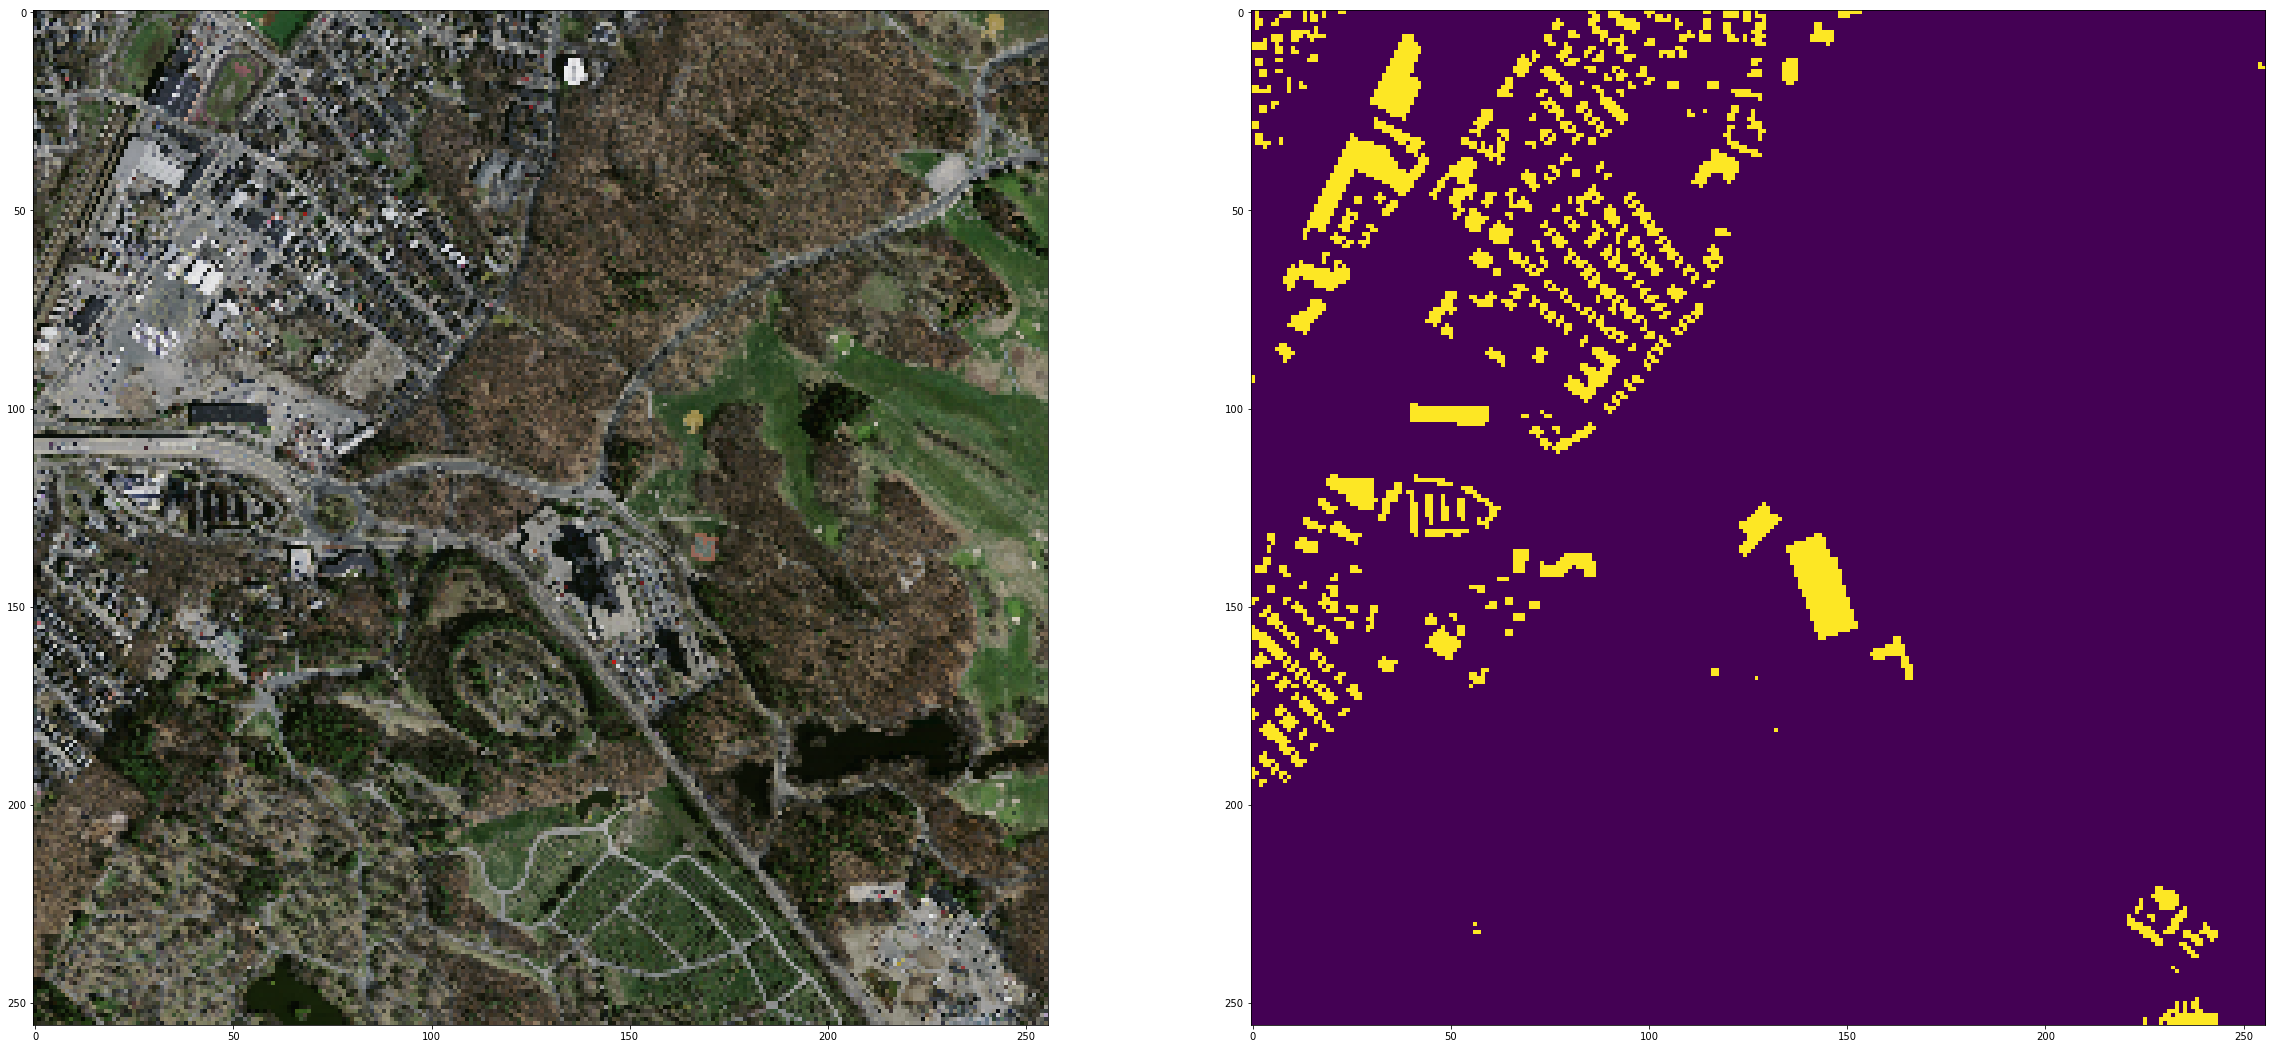

In [4]:
#double check that the training images and masks were loaded correctly
x = random.randint(0, len(X_train))
plt.rcParams['figure.figsize'] = [40,20]
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(X_train[x])
f.add_subplot(1,2,2)
plt.imshow(Y_train[x])
plt.show()
#print(x)

<h1>Neural Network Architecture</h1>

The task at hand is very similar to a segmenting medical images. The <a href = 'https://www.kaggle.com/c/data-science-bowl-2018'> 2018 Data Science Bowl</a> was a competition in which participants performed segmentation on medical images. The top two finalists both used variations on <a href = 'https://arxiv.org/abs/1505.04597'>U-nets</a>. As such, a U-net is likely to be a good architecture for the building segmentation problem.

An example U-net architecture:
<img src='https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/u-net-architecture.png'>

In [5]:
# Build U-Net model
# initally had relu activation because it's the most popular, but researched elu, and it empirically improved validation loss
# batchnormilaztion should provide regularization


inputs = Input((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = BatchNormalization()(s)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
#print(keras.backend.int_shape(c1))
p1 = MaxPooling2D((2, 2)) (c1)

c2 = BatchNormalization()(p1)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
#print(keras.backend.int_shape(c2))
p2 = MaxPooling2D((2, 2)) (c2)

c3 = BatchNormalization()(p2)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
#print(keras.backend.int_shape(c3))
p3 = MaxPooling2D((2, 2)) (c3)

c4 = BatchNormalization()(p3)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
#print(keras.backend.int_shape(c4))
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = BatchNormalization()(p4)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

#print(keras.backend.int_shape(c5))

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = BatchNormalization()(u6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)


u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = BatchNormalization()(u7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = BatchNormalization()(u8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = BatchNormalization()(u9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

#sigmoid so that the output can be interpreted as a probability that a building is located there
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
#model.summary()

In [7]:
#enable early stopping in order to stop overfitting once the validation loss begins to increase
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min')
results = model.fit(X_train, Y_train[...,np.newaxis], validation_split=0.1,batch_size=16, epochs=100)

Train on 103 samples, validate on 12 samples
Epoch 1/100
103/103 [==============================] - 11s 102ms/step - loss: 0.6909 - val_loss: 0.3953
Epoch 2/100
103/103 [==============================] - 2s 22ms/step - loss: 0.4964 - val_loss: 0.3583
Epoch 3/100
103/

In [8]:
#make predictions on the training set
preds_train = model.predict(X_train)

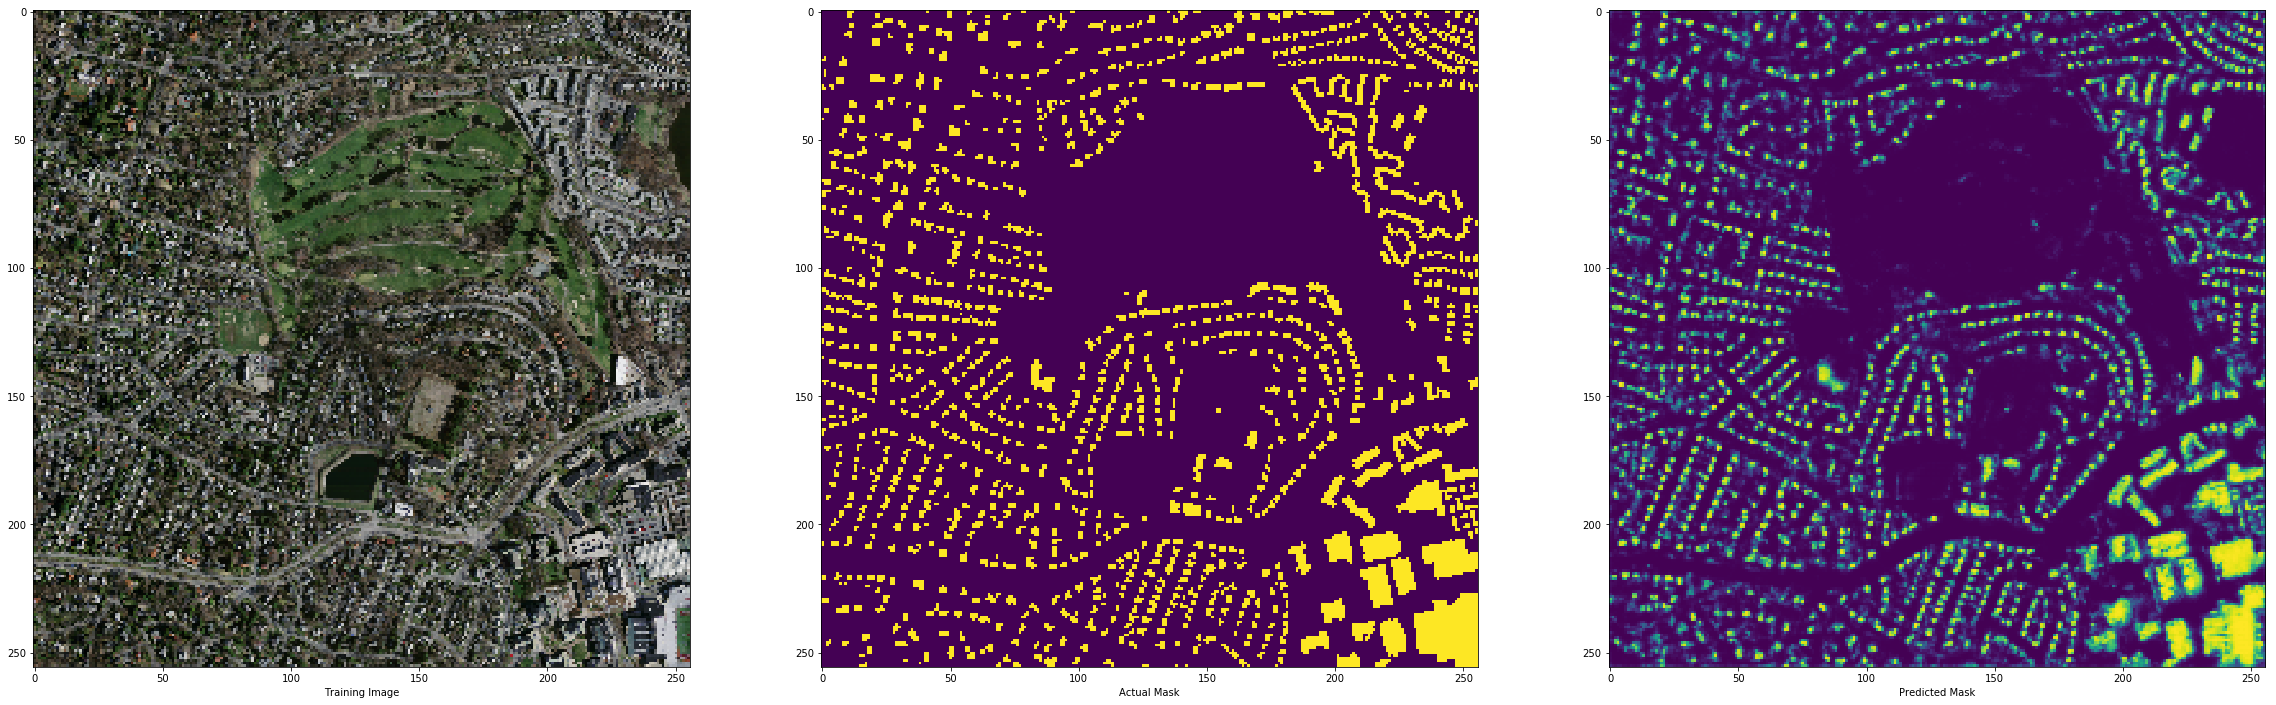

In [9]:
#sanity check on training examples
#3 panels, 1st - input image, 2nd - ground truth mask, 3rd - the model's prediction
#x = random.randint(0, len(preds_train))
x=5
plt.rcParams['figure.figsize'] = [40,20]
f = plt.figure()
f.add_subplot(1,3,1, xlabel = 'Training Image')
plt.imshow(X_train[x])
f.add_subplot(1,3,2, xlabel = 'Actual Mask')
plt.imshow(np.squeeze(Y_train[x]))
f.add_subplot(1,3,3, xlabel = 'Predicted Mask')
plt.imshow(np.squeeze(preds_train[x]))
plt.show()

In [10]:
#made predictions for the test data
preds_test = model.predict(X_test)

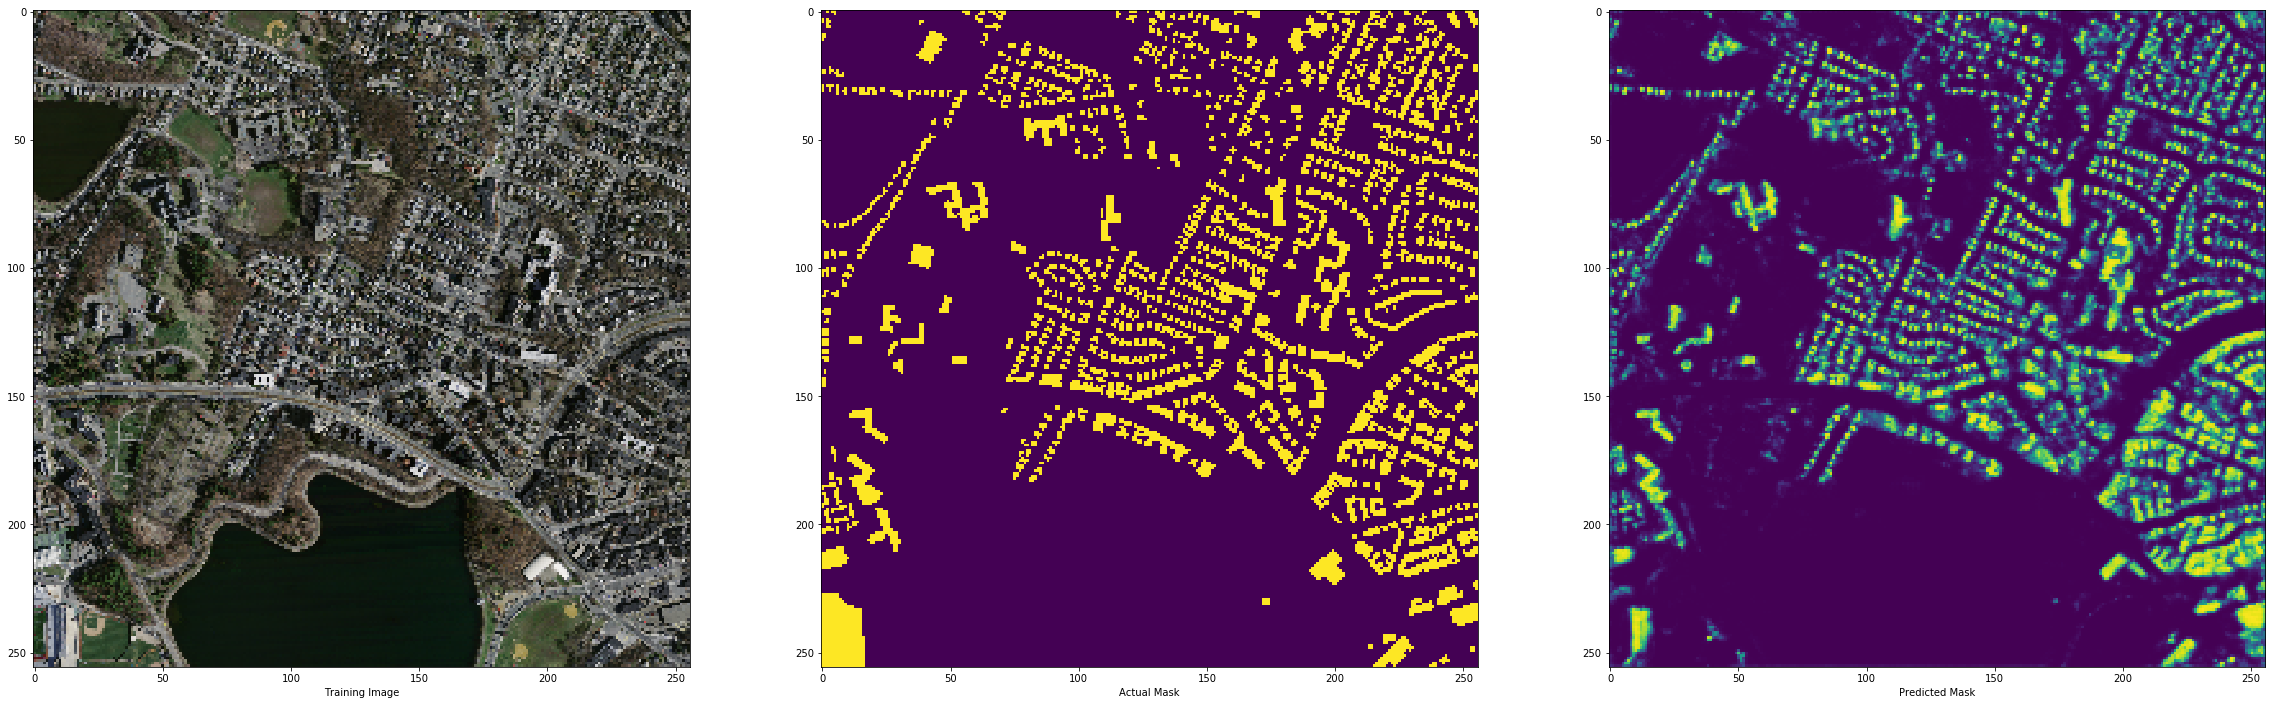

In [11]:
# Compare test image, actual test mask, and prediction
x = random.randint(0, len(preds_test)-1)
plt.rcParams['figure.figsize'] = [40,20]
f = plt.figure()
f.add_subplot(1,3,1, xlabel = 'Training Image')
plt.imshow(X_test[x])
f.add_subplot(1,3,2, xlabel = 'Actual Mask')
plt.imshow(np.squeeze(Y_test[x]))
f.add_subplot(1,3,3, xlabel = 'Predicted Mask')
plt.imshow(np.squeeze(preds_test[x]))
plt.show()

In [13]:
#calculating the accuracy metrics: accuracy, precision, and recall

#threshold is the threshold in confidence for saying a pixel belongs to a building
threshold = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
TPR = [0]*11
FPR = [0]*11

for i in range(0, len(threshold)):
    #all possible outcomes
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    
    for j in range(0, len(preds_test)):    
        for x in range(0, IMG_HEIGHT):
            for y in range(0, IMG_WIDTH):                
                if Y_test[j][x][y] == 1:
                    if preds_test[j][x][y]> threshold[i]:
                        true_positives += 1
                    else:
                        false_negatives += 1
                else:
                    if preds_test[j][x][y] > threshold[i]:
                        false_positives += 1
                    else:
                        true_negatives += 1
    #calculate metrics               
    accuracy = (true_positives + true_negatives)/(len(preds_test) * IMG_HEIGHT * IMG_WIDTH)
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/(true_positives + false_negatives)
    
    #save data for ROC curve
    TPR[i] = recall
    FPR[i] = false_positives/(false_positives + true_negatives)

    print('For prediction threshold = %.2f%%.' % (threshold[i]*100))
    print("Accuracy = %.2f%%." % (accuracy*100))
    print("Precision = %.2f%%." % (precision*100))
    print("Recall = %.2f%%." % (recall*100))


For prediction threshold = 0.00%.
Accuracy = 21.16%.
Precision = 21.16%.
Recall = 100.00%.
For prediction threshold = 10.00%.
Accuracy = 81.19%.
Precision = 53.55%.
Recall = 83.90%.
For prediction threshold = 20.00%.
Accuracy = 85.38%.
Precision = 63.10%.
Recall = 74.37%.
For prediction threshold = 30.00%.
Accuracy = 86.85%.
Precision = 70.01%.
Recall = 66.23%.
For prediction threshold = 40.00%.
Accuracy = 87.18%.
Precision = 75.39%.
Recall = 58.54%.
For prediction threshold = 50.00%.
Accuracy = 86.94%.
Precision = 79.82%.
Recall = 51.22%.
For prediction threshold = 60.00%.
Accuracy = 86.32%.
Precision = 83.87%.
Recall = 43.74%.
For prediction threshold = 70.00%.
Accuracy = 85.28%.
Precision = 87.44%.
Recall = 35.55%.
For prediction threshold = 80.00%.
Accuracy = 83.73%.
Precision = 90.77%.
Recall = 25.72%.
For prediction threshold = 90.00%.
Accuracy = 81.41%.
Precision = 94.24%.
Recall = 12.92%.
For prediction threshold = 99.00%.
Accuracy = 78.86%.
Precision = 100.00%.
Recall = 0.09%.

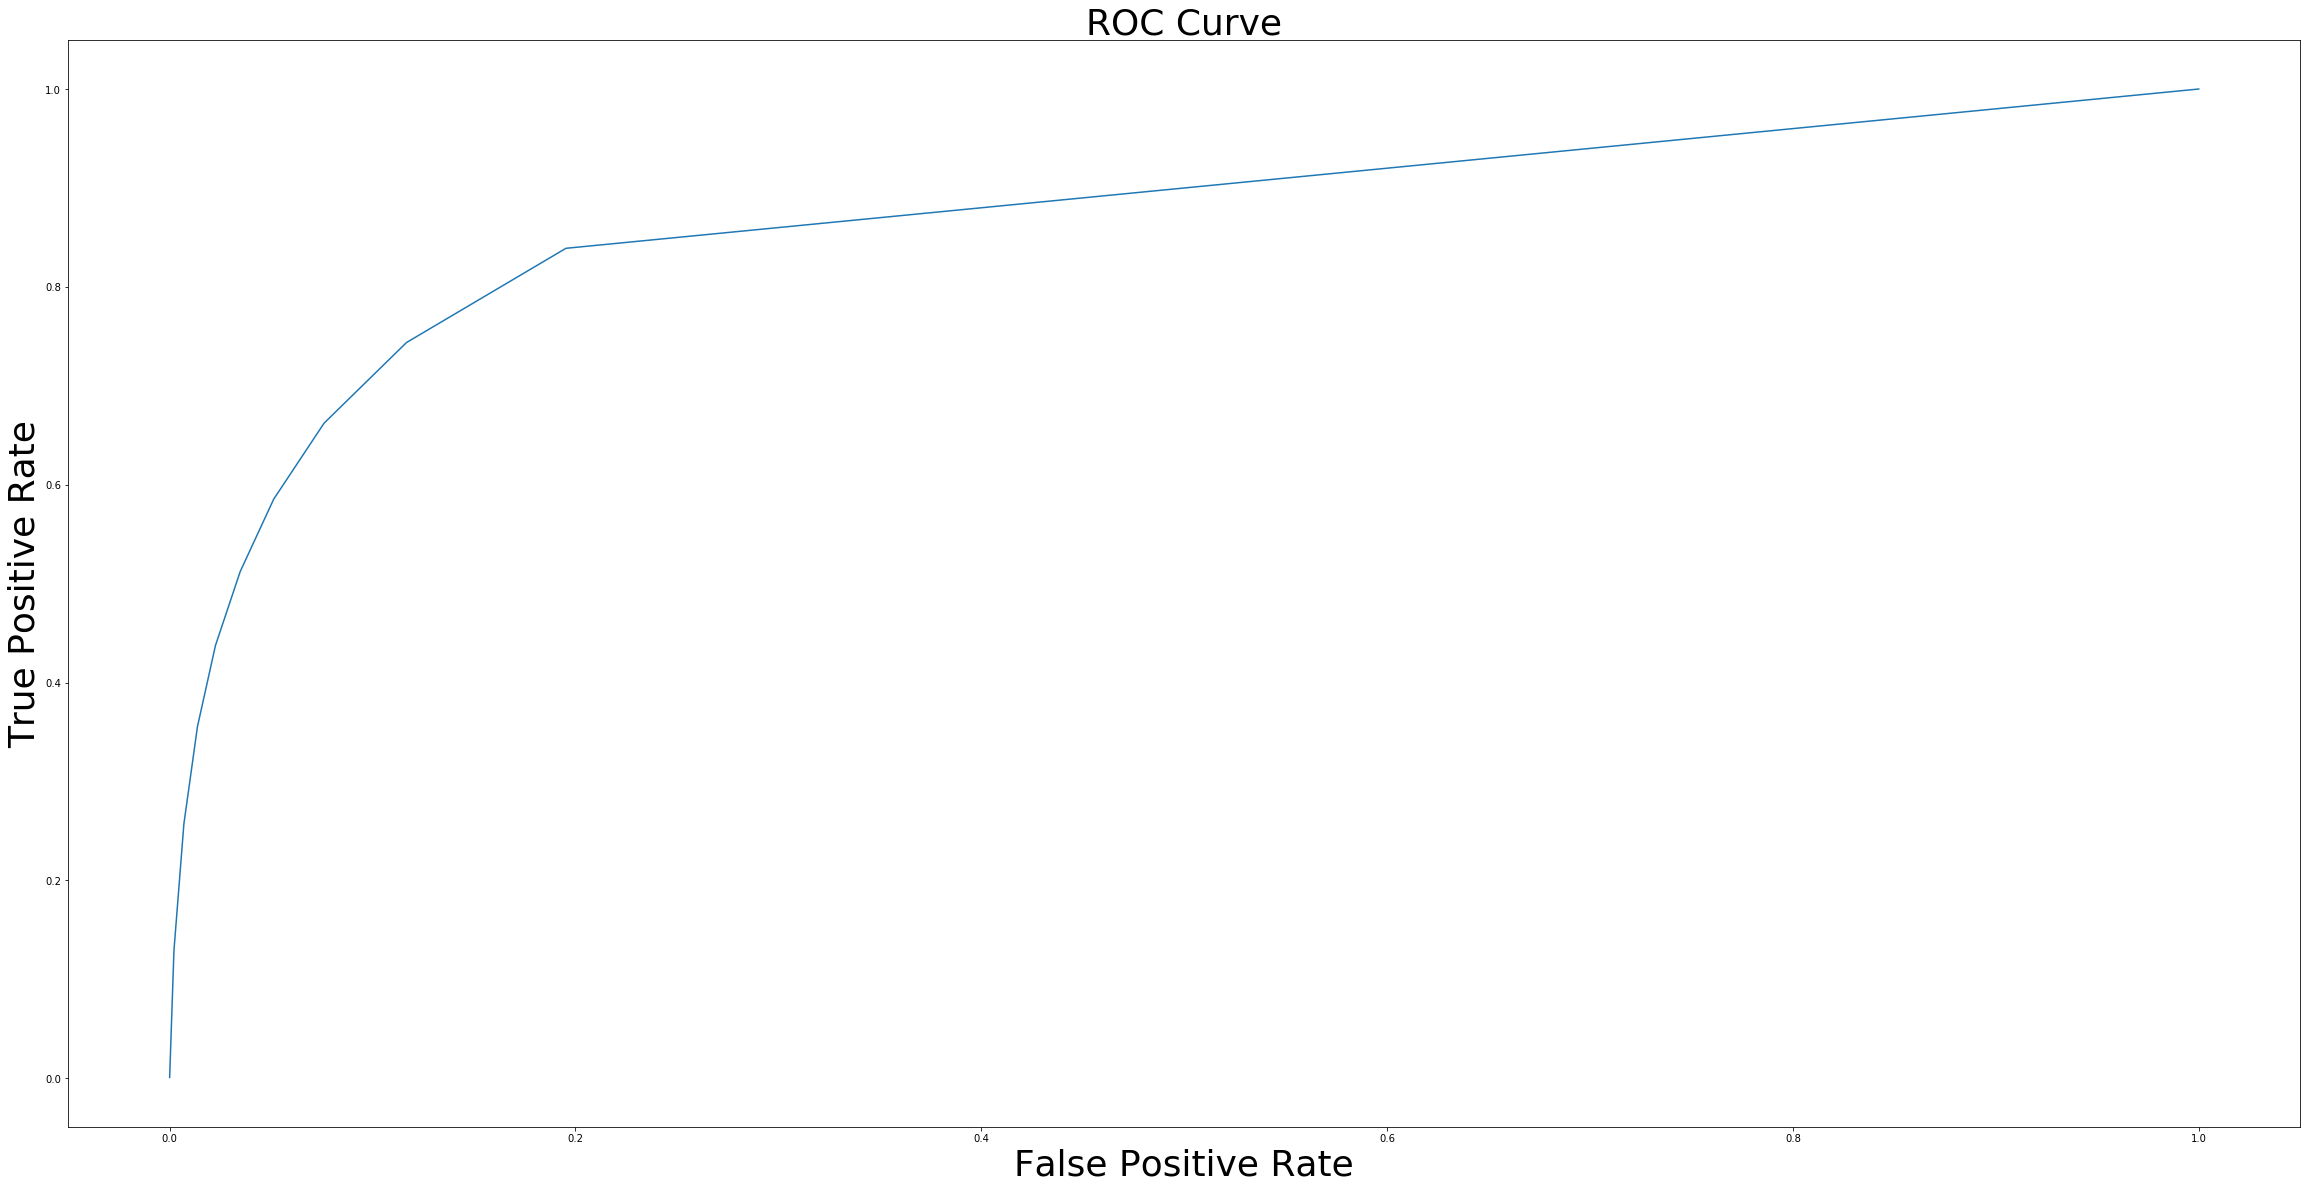

In [15]:
#plotting Receiver operating characteristic curve

fig, ax = plt.subplots()
ax.plot(FPR, TPR)
plt.title('ROC Curve', {'fontsize':36})
plt.xlabel('False Positive Rate', {'fontsize':36})
plt.ylabel('True Positive Rate', {'fontsize':36})
plt.show()
